## 02. Neural Network Classification with Pytorch

## 1. Make classification data and get it ready

In [ ]:
import sklearn

In [ ]:
from sklearn.datasets import make_circles

#Make 1000 sample
n_samples = 1000

#Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)


In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [ ]:
# Make dataframe of circle data
import pandas as pd
circles = pd.DataFrame({'X1' : X[:, 0],
                        'X2' :X[:, 1],
                        'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


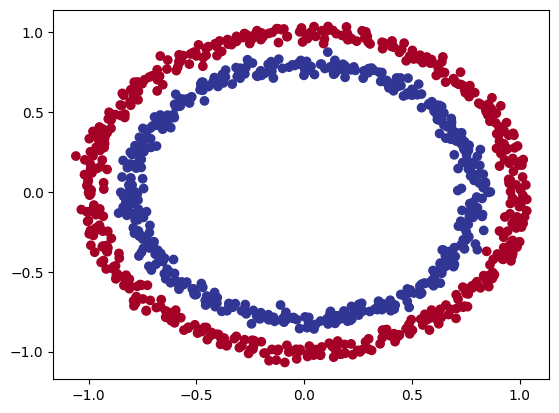

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y = X[:, 1],
            c= y,
            cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Turn data into tensors and create train and test splits

In [ ]:
import torch
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [ ]:
X = X.type(torch.float)
y = y.type(torch.float)

In [ ]:
#split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 42)




## 2. Building a model

1. Setup device agnostic code
2. Construct a model by subclassing nn.Module
3. Define a loss function and optimier
4. Create a training and test loop



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from torch import nn
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    #infeatures of layer 1 has to match with outfeatures of 1
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x-> layer 1-> layer 2 -> output

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
#Let.s replace the model with nn.Sequential()
# with torch.inference_mode(): # Remove inference mode here
model_0 = nn.Sequential(
  nn.Linear(in_features=2, out_features=5),
  nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
X_test.dtype

torch.float32

In [ ]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"The predictions is {untrained_preds[:10]}")
print(f"The labels are  {y_test[:10]}")

The predictions is tensor([[ 0.5251],
        [ 0.4584],
        [ 0.4223],
        [ 0.5553],
        [-0.0182],
        [-0.0555],
        [ 0.1059],
        [-0.0155],
        [ 0.4411],
        [ 0.4491]], device='cuda:0')
The labels are  tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


## 2.1 Loss function and optimier
Which loss function or optimier should you use?

For regression you might want MAE or MSE
For classification you might want binary cross entropy

For optimier SDG and Adam are the most usefull

In [ ]:
#loss_fn = nn.BCELoss() #this requires input to have gone through the sigmoid activation
loss_fn = nn.BCEWithLogitsLoss() # has sigmoid activiation built in

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6696, -0.1187],
                      [-0.6206, -0.5102],
                      [-0.4753, -0.6509],
                      [-0.2093, -0.4018],
                      [-0.1701,  0.4526]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1614, -0.4033,  0.3211, -0.1200, -0.4207], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.4107, -0.0733,  0.1842, -0.3507,  0.4372]], device='cuda:0')),
             ('1.bias', tensor([0.2509], device='cuda:0'))])

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train Model

To train our model build a training loop

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (back propagation)
5. Optimizer step (gradient desecent)


## 3.1 going from raw logits -> prediction porbabilites - prediction labels

Our model outputs are going to be raw **logits**

We can convert these logits into prediction probabilities by passing them to some kind of activation function (e.g sigmoid for binary classification and softmax for multiclass classification)

then we can covert our model's prediction probabilities to prediction labels by either rounding them or taaking the argmax()

In [ ]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logit = model_0(X_test.to(device))

y_logit[:5]

tensor([[ 0.5251],
        [ 0.4584],
        [ 0.4223],
        [ 0.5553],
        [-0.0182]], device='cuda:0')

In [ ]:
#Use the sigmoid activation function on our model logit to turn them into predicition probability
y_pred_prob = torch.sigmoid(y_logit)
y_pred_prob

tensor([[0.6283],
        [0.6126],
        [0.6040],
        [0.6354],
        [0.4955],
        [0.4861],
        [0.5265],
        [0.4961],
        [0.6085],
        [0.6104],
        [0.6404],
        [0.6185],
        [0.5079],
        [0.5820],
        [0.6231],
        [0.5011],
        [0.5704],
        [0.6524],
        [0.6363],
        [0.6515],
        [0.6142],
        [0.4744],
        [0.6377],
        [0.6594],
        [0.5539],
        [0.5138],
        [0.5346],
        [0.4707],
        [0.6294],
        [0.5660],
        [0.5417],
        [0.5610],
        [0.6388],
        [0.5180],
        [0.6456],
        [0.5958],
        [0.6270],
        [0.5891],
        [0.5311],
        [0.5746],
        [0.6397],
        [0.6201],
        [0.5681],
        [0.4868],
        [0.6417],
        [0.5908],
        [0.4817],
        [0.6180],
        [0.5990],
        [0.4900],
        [0.6363],
        [0.6422],
        [0.4746],
        [0.4947],
        [0.5216],
        [0

In [ ]:
# Find the predicition labels
y_preds = torch.round(y_pred_prob)

#in full (logits -> pred prob -> pred labels)
with torch.inference_mode():
  y_logit_test = model_0(X_test.to(device))

#y_pred_labels = torch.round(torch.sigmoid(y_logit_test[:5]))

# Check for equality - comparing the first 5 predictions with the first 5 true labels
print(torch.eq(y_preds.squeeze()[:5], y_test[:5].squeeze().to(device)))

#Get rid of extra dimension
y_preds.squeeze()

tensor([ True, False,  True, False, False], device='cuda:0')


tensor([1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 1.], device='cuda:0')

In [ ]:
### 2 Building and training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set the number of epochs
epochs = 100

#put data to target device
X_train, y_train  = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Build training and evaluation loop
for epoch in range(epochs):
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. caclulate loss/accuracy
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (back propagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()


## Improving a model

 * Add more layers - give the model more chances to learn about pattenrs in the data
 * Add more hidden units
 * Fit for longer
 * Changing the activation function
 * Change optimiation function
 * Fit for longer
 * Change learning rate

In [ ]:
import torch
from torch import nn
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    #  z = self.layer_1(x)
    #  z = self.layer_2(z)
    #  z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [ ]:
#Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculate the loss
  loss = loss_fn(y_logits, y_train)

  #3. optimizer zero grad
  optimizer.zero_grad()

  #loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  ###Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    #calculate the loss
    test_loss = loss_fn(test_logits, y_test)

    #Print out what's happening
    if epoch % 100 == 0:
      print(f' Epoch : {epoch} | Loss: {loss: .5f} | Test loss : {test_loss: .5f}')

 Epoch : 0 | Loss:  0.69396 | Test loss :  0.69261
 Epoch : 100 | Loss:  0.69305 | Test loss :  0.69379
 Epoch : 200 | Loss:  0.69299 | Test loss :  0.69437
 Epoch : 300 | Loss:  0.69298 | Test loss :  0.69458
 Epoch : 400 | Loss:  0.69298 | Test loss :  0.69465
 Epoch : 500 | Loss:  0.69298 | Test loss :  0.69467
 Epoch : 600 | Loss:  0.69298 | Test loss :  0.69468
 Epoch : 700 | Loss:  0.69298 | Test loss :  0.69468
 Epoch : 800 | Loss:  0.69298 | Test loss :  0.69468
 Epoch : 900 | Loss:  0.69298 | Test loss :  0.69468


### 5.1 preparing data to see if our model can fit a straight line

In [ ]:
import torch
from torch import nn
weight = 0.7
bias = 0.3
step = 0.01
start = 0
stop = 1
X = torch.arange(start, stop, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10], X.dtype, y.dtype

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400],
         [0.0500],
         [0.0600],
         [0.0700],
         [0.0800],
         [0.0900]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280],
         [0.3350],
         [0.3420],
         [0.3490],
         [0.3560],
         [0.3630]]),
 torch.float32,
 torch.float32)

In [ ]:
# Split the linear data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_linear.shape, X_test_linear.shape, y_train_linear.shape, y_test_linear.shape

(torch.Size([80, 1]),
 torch.Size([20, 1]),
 torch.Size([80, 1]),
 torch.Size([20, 1]))

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(in_features= 1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
#Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params= model_2.parameters(), lr=0.1)

In [ ]:
# Train
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 1000
# Put the data on the target device
X_train, y_train = X_train_linear.to(device), y_train_linear.to(device)
X_test, y_test = X_test_linear.to(device), y_test_linear.to(device)
for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train)
  loss = loss_fn(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test)
    test_loss = loss_fn(test_pred, y_test)

  #print wout whats happenin;
  if epoch % 100 == 0:
    print(f'Epoch : {epoch} | loss : {loss} | test loss : {test_loss}')

Epoch : 0 | loss : 0.80353182554245 | test loss : 0.39553770422935486
Epoch : 100 | loss : 0.08341104537248611 | test loss : 0.08491416275501251
Epoch : 200 | loss : 0.07810086756944656 | test loss : 0.06756555289030075
Epoch : 300 | loss : 0.048623599112033844 | test loss : 0.07826316356658936
Epoch : 400 | loss : 0.047833021730184555 | test loss : 0.08699508756399155
Epoch : 500 | loss : 0.04515540227293968 | test loss : 0.08613546192646027
Epoch : 600 | loss : 0.049217116087675095 | test loss : 0.07968028634786606
Epoch : 700 | loss : 0.06312743574380875 | test loss : 0.051040150225162506
Epoch : 800 | loss : 0.04972308129072189 | test loss : 0.07560808956623077
Epoch : 900 | loss : 0.05599554255604744 | test loss : 0.06825637072324753


## The missing piece : non-Linearity

What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?

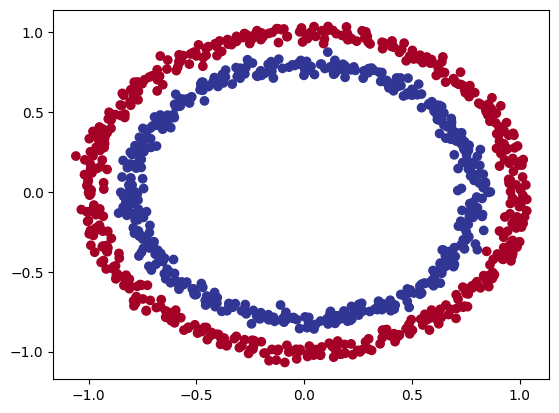

In [ ]:
#Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y  = make_circles(n_samples, noise = 0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
# convert data to tensors and then to train and tes split
import torch
from sklearn.model_selection import train_test_split

#Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [ ]:
### 6.2 Building a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLu() #relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2.to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
## Setup loss and optimier
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr =0.1)

In [ ]:
## Train a model with non-Linearity
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_3.train()

  #forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze() # Squeeze test_logits
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)

  if epoch % 100 == 0: # Changed print frequency
    print(f'Epoch : {epoch} | Loss : {loss:.4f}, Acc : {acc: .2f}% | Test Loss: {test_loss: .4f}, Test Acc: {test_acc: .2f}%')

Epoch : 0 | Loss : 0.6929, Acc :  50.00% | Test Loss:  0.6932, Test Acc:  50.00%
Epoch : 100 | Loss : 0.6912, Acc :  52.88% | Test Loss:  0.6910, Test Acc:  52.50%
Epoch : 200 | Loss : 0.6898, Acc :  53.37% | Test Loss:  0.6894, Test Acc:  55.00%
Epoch : 300 | Loss : 0.6879, Acc :  53.00% | Test Loss:  0.6872, Test Acc:  56.00%
Epoch : 400 | Loss : 0.6852, Acc :  52.75% | Test Loss:  0.6841, Test Acc:  56.50%
Epoch : 500 | Loss : 0.6810, Acc :  52.75% | Test Loss:  0.6794, Test Acc:  56.50%
Epoch : 600 | Loss : 0.6751, Acc :  54.50% | Test Loss:  0.6729, Test Acc:  56.00%
Epoch : 700 | Loss : 0.6666, Acc :  58.38% | Test Loss:  0.6632, Test Acc:  59.00%
Epoch : 800 | Loss : 0.6516, Acc :  64.00% | Test Loss:  0.6476, Test Acc:  67.50%
Epoch : 900 | Loss : 0.6236, Acc :  74.00% | Test Loss:  0.6215, Test Acc:  79.00%


In [ ]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6760,  0.8035],
                      [-0.1997,  0.7568],
                      [-0.1549,  0.1427],
                      [-0.9637,  0.2292],
                      [ 0.5717, -1.3426],
                      [ 0.6689,  0.1840],
                      [ 0.7970,  0.2595],
                      [ 0.3410, -0.0998],
                      [ 0.6555,  0.3186],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3761, -0.2008, -0.2872,  0.2803, -0.4513, -0.3364, -0.3300, -0.4252,
                      -0.1989, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 1.3081e-01, -3.7347e-01,  2.4414e-01, -4.3348e-02, -2.7270e-01,
                        1.0512e-01, -4.7109e-02,  2.5550e-01, -4.9248e-02, -9.9730e-02],
                      [ 7.9469e-01,  3.8277e-01,  1.3309e-01,  7.5399e-01,  9.7241e-01,
                        2.6996e-01,  6.2185e-01

### 6.4 Evaluating a model traned with nonlinear activation functions

In [ ]:
#Makes prediction
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_pred[:10], y_test[:10]

(tensor([1., 0., 0., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

NameError: name 'plot_decision_boundary' is not defined

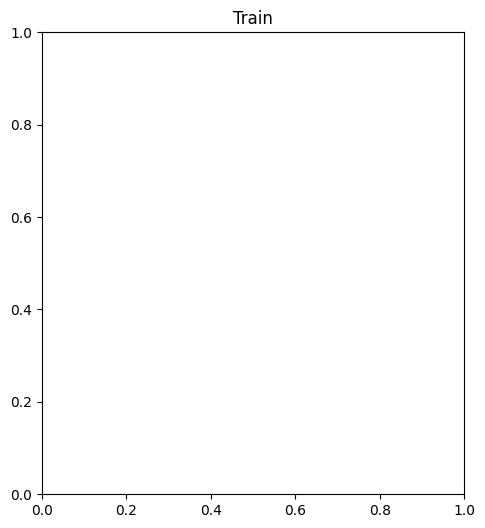

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1) #no of rows, column, index
plt.title("Train")
plot_decision_boundary(model_3, X_train)

#7. Replicating non-linear activation functions
Neural network is a big stack of linear and non-linear functions

In [ ]:
#Create a tensor
A = torch.arange(-10,10,1, dtype=torch.float32)
A.dtype

torch.float32

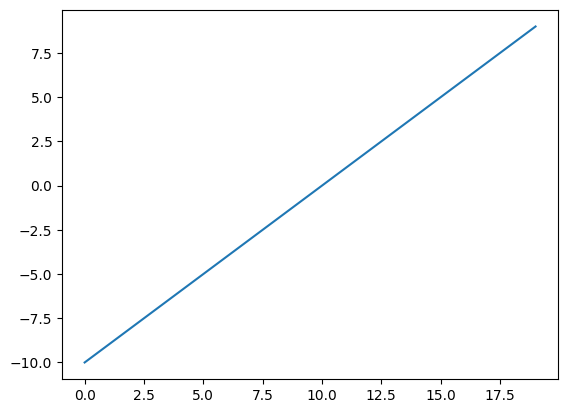

In [ ]:
plt.plot(A)

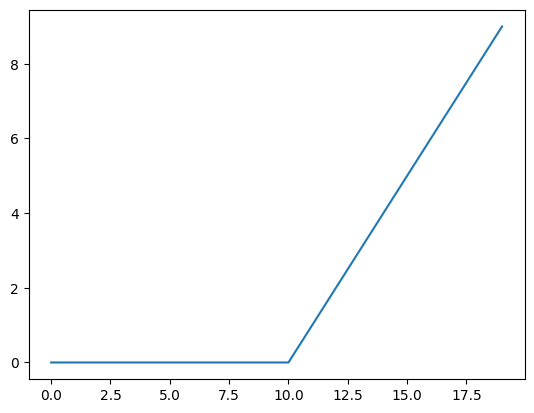

In [ ]:
plt.plot(torch.relu(A))

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x) #inputs must be tensors
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [ ]:
def sigmoid(x):
  return 1/ (1 + torch.exp(-x))

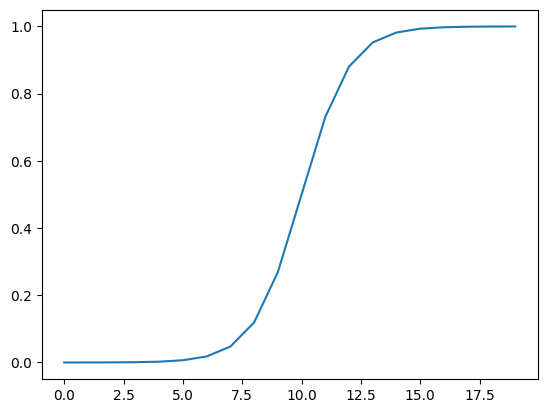

In [ ]:
plt.plot(torch.sigmoid(A))

###. Putting it all together with a multi-class classification problem


### 8.1 Creating a toy multi-class dataset

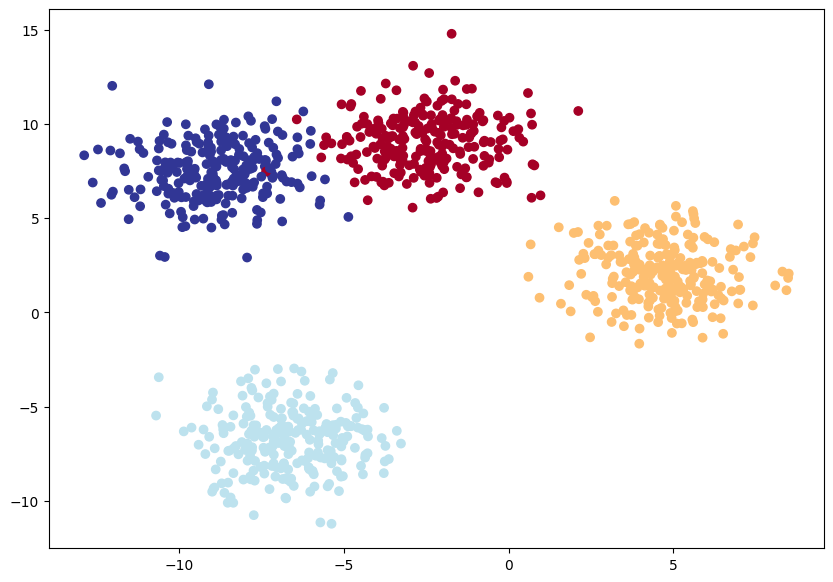

In [ ]:
#import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#set the hyperparameters for data creation
NUM_CLASSES  = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5, #give the clusters a big shake up
                            random_state = RANDOM_SEED)

#2. Turn data in tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split in training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size = 0.2, random_state = RANDOM_SEED)

#4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap = plt.cm.RdYlBu)




##8.2 Building a multiclass classification model in PyTorch

In [ ]:
#create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

#Create an instance
model_4 = BlobModel(input_features = 2,
                    output_features = 4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
#loss function
loss_fn = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.1)

In [ ]:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [ ]:
y_logits = model_4(X_blob_test)

In [ ]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.], device='cuda:0')

In [ ]:
#convert our models logit outputs to prediciton probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[0.3447, 0.1894, 0.2634, 0.2024],
        [0.3468, 0.2143, 0.1739, 0.2650],
        [0.3011, 0.3310, 0.2090, 0.1589],
        [0.3021, 0.2543, 0.2566, 0.1870],
        [0.3544, 0.2176, 0.2453, 0.1828],
        [0.3547, 0.2067, 0.1543, 0.2843],
        [0.2950, 0.3359, 0.2138, 0.1553],
        [0.3407, 0.2395, 0.2147, 0.2050],
        [0.3092, 0.3302, 0.1981, 0.1625],
        [0.3429, 0.2349, 0.2275, 0.1948]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
#convert prediction probabilities to prediction label
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')

### 8.5 training loop and testing loo for a multi-class PyTorch model

In [ ]:
import torch # Re-import torch to ensure torch.manual_seed is the function
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 100

# Cast target tensors to torch.long
y_blob_train = y_blob_train.long()
y_blob_test = y_blob_test.long()

for epoch in range(epochs):
  model_4.train()
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ###Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits= model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)

    if epoch % 10 == 0:
      print(f'Epoch : {epoch} | Loss : {loss:.4f}, Acc : {acc: .2f}% | Test Loss: {test_loss: .4f}, Test Acc: {test_acc: .2f}%')

Epoch : 0 | Loss : 1.3354, Acc :  25.37% | Test Loss:  1.1542, Test Acc:  54.00%
Epoch : 10 | Loss : 0.7811, Acc :  95.25% | Test Loss:  0.7181, Test Acc:  97.00%
Epoch : 20 | Loss : 0.2731, Acc :  99.38% | Test Loss:  0.2370, Test Acc:  99.50%
Epoch : 30 | Loss : 0.1093, Acc :  99.50% | Test Loss:  0.0979, Test Acc:  99.50%
Epoch : 40 | Loss : 0.0672, Acc :  99.50% | Test Loss:  0.0590, Test Acc:  99.50%
Epoch : 50 | Loss : 0.0508, Acc :  99.38% | Test Loss:  0.0430, Test Acc:  99.50%
Epoch : 60 | Loss : 0.0425, Acc :  99.38% | Test Loss:  0.0345, Test Acc:  99.50%
Epoch : 70 | Loss : 0.0376, Acc :  99.38% | Test Loss:  0.0294, Test Acc:  99.50%
Epoch : 80 | Loss : 0.0344, Acc :  99.38% | Test Loss:  0.0260, Test Acc:  99.50%
Epoch : 90 | Loss : 0.0322, Acc :  99.38% | Test Loss:  0.0236, Test Acc:  99.50%


### A few more classification metrics
* Accuracy (for balanced classes)
* Precision
* Recall
* F1-score
* Confusion metrics
* Classification report

In [ ]:
pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 18.3 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

acc = Accuracy().to(device)